In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_dataset():
    data = "hello world hello world hello world"
    chars = list(set(data))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}

    # Prepare training data
    X = []  # Input sequences
    y = []  # Target sequences

    for i in range(len(data) - 1):
        input_char = np.zeros((len(chars)))
        input_char[char_to_idx[data[i]]] = 1

        target_char = np.zeros((len(chars)))
        target_char[char_to_idx[data[i + 1]]] = 1

        X.append(input_char)
        y.append(target_char)

    return np.array(X), np.array(y), char_to_idx, idx_to_char, data


In [3]:
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # Initialize weights
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01  # Input → Hidden
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # Hidden → Hidden
        self.Why = np.random.randn(output_size, hidden_size) * 0.01  # Hidden → Output

        # Initialize biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def forward(self, inputs):
        self.hidden_states = []
        self.outputs = []
        h_prev = np.zeros((self.Whh.shape[0], 1))

        for x in inputs:
            x = x.reshape(-1, 1)
            h = self.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
            y = self.sigmoid(np.dot(self.Why, h) + self.by)

            self.hidden_states.append(h)
            self.outputs.append(y)
            h_prev = h

        return self.outputs

    def backward(self, inputs, targets, outputs, hidden_states):
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dh_next = np.zeros_like(hidden_states[0])

        for t in reversed(range(len(outputs))):
            dy = outputs[t] - targets[t].reshape(-1, 1)
            dWhy += np.dot(dy, hidden_states[t].T)
            dby += dy

            dh = np.dot(self.Why.T, dy) + dh_next
            dh_raw = self.tanh_derivative(hidden_states[t]) * dh

            dbh += dh_raw
            dWxh += np.dot(dh_raw, inputs[t].reshape(1, -1))
            if t > 0:
                dWhh += np.dot(dh_raw, hidden_states[t - 1].T)
            else:
                dWhh += np.dot(dh_raw, np.zeros_like(hidden_states[0]).T)

            dh_next = np.dot(self.Whh.T, dh_raw)

        # Gradient clipping
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)

        # Update weights
        self.Wxh -= self.learning_rate * dWxh
        self.Whh -= self.learning_rate * dWhh
        self.Why -= self.learning_rate * dWhy
        self.bh -= self.learning_rate * dbh
        self.by -= self.learning_rate * dby


In [4]:
def train_and_demonstrate():
    X, y, char_to_idx, idx_to_char, original_data = create_dataset()

    input_size = len(char_to_idx)
    hidden_size = 50
    output_size = len(char_to_idx)

    rnn = SimpleRNN(input_size, hidden_size, output_size)
    epochs = 100
    losses = []

    print("Training the RNN...")
    print("Original sequence:", original_data)
    print("\nTraining Progress:")

    for epoch in range(epochs):
        outputs = rnn.forward(X)
        loss = np.mean([(output - target.reshape(-1, 1)) ** 2
                        for output, target in zip(outputs, y)])
        losses.append(loss)
        rnn.backward(X, y, outputs, rnn.hidden_states)

        if epoch % 20 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    print("\nDemonstrating predictions for each character in sequence:")
    for i in range(len(original_data) - 1):
        input_char = original_data[i]
        actual_next_char = original_data[i + 1]

        input_vector = np.zeros((len(char_to_idx)))
        input_vector[char_to_idx[input_char]] = 1

        output = rnn.forward([input_vector])[0]
        predicted_char = idx_to_char[np.argmax(output)]
        print(f"Input: '{input_char}' → Predicted next: '{predicted_char}' (Actual: '{actual_next_char}')")

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return rnn, char_to_idx, idx_to_char


Training the RNN...
Original sequence: hello world hello world hello world

Training Progress:
Epoch 0, Loss: 0.2500
Epoch 20, Loss: 0.1056
Epoch 40, Loss: 0.1046
Epoch 60, Loss: 0.0999
Epoch 80, Loss: 0.0607
Epoch 99, Loss: 0.0336

Demonstrating predictions for each character in sequence:
Input: 'h' → Predicted next: 'e' (Actual: 'e')
Input: 'e' → Predicted next: 'l' (Actual: 'l')
Input: 'l' → Predicted next: 'l' (Actual: 'l')
Input: 'l' → Predicted next: 'l' (Actual: 'o')
Input: 'o' → Predicted next: 'r' (Actual: ' ')
Input: ' ' → Predicted next: 'w' (Actual: 'w')
Input: 'w' → Predicted next: 'o' (Actual: 'o')
Input: 'o' → Predicted next: 'r' (Actual: 'r')
Input: 'r' → Predicted next: 'l' (Actual: 'l')
Input: 'l' → Predicted next: 'l' (Actual: 'd')
Input: 'd' → Predicted next: ' ' (Actual: ' ')
Input: ' ' → Predicted next: 'w' (Actual: 'h')
Input: 'h' → Predicted next: 'e' (Actual: 'e')
Input: 'e' → Predicted next: 'l' (Actual: 'l')
Input: 'l' → Predicted next: 'l' (Actual: 'l')
Inpu

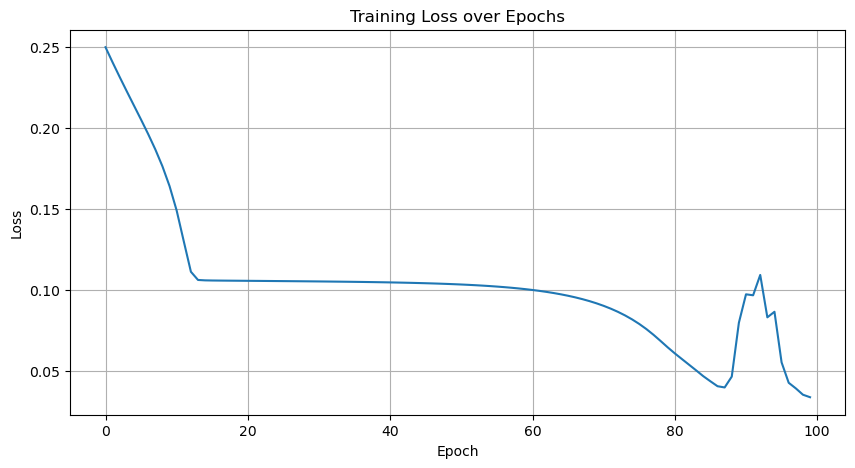

In [5]:
rnn, char_to_idx, idx_to_char = train_and_demonstrate()
